<a href="https://colab.research.google.com/github/28tripleC/Image2CAD/blob/main/Image2CAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed May 28 10:07:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   47C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
!pip install faiss-cpu transformers timm pillow opencv-python matplotlib --quiet
!pip install trimesh --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.2/711.2 kB 38.6 MB/s eta 0:00:00


## Install Grounding DINO 🦕

In [5]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!git clone https://github.com/facebookresearch/segment-anything.git

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 463 (delta 175), reused 136 (delta 136), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 17.39 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Cloning into 'segment-anything'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 304 (delta 2), reused 1 (delta 1), pack-reused 299 (from 2)
Receiving objects: 100% (304/304), 18.31 MiB | 12.91 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [6]:
%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn


In [7]:
%cd {HOME}/GroundingDINO
!pip install -q -e .

/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 24.4 MB/s eta 0:00:00


In [8]:
%cd {HOME}/segment-anything
!pip install -q -e .

/content/segment-anything
  Preparing metadata (setup.py) ... done


In [9]:
import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


## Download Grounding DINO Weights 🏋️

In [10]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [11]:
import os

WEIGHTS_NAME_1 = "groundingdino_swint_ogc.pth"
WEIGHTS_NAME_2 = "sam_vit_h_4b8939.pth"

WEIGHTS_PATH_1 = os.path.join(HOME, "weights", WEIGHTS_NAME_1)
WEIGHTS_PATH_2 = os.path.join(HOME, "weights", WEIGHTS_NAME_2)

print(WEIGHTS_PATH_1, "; exist:", os.path.isfile(WEIGHTS_PATH_1))
print(WEIGHTS_PATH_2, "; exist:", os.path.isfile(WEIGHTS_PATH_1))

/content/weights/groundingdino_swint_ogc.pth ; exist: True
/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Grounding DINO Model

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
%cd {HOME}/GroundingDINO

import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict, load_model

model_GDino = load_model(CONFIG_PATH, WEIGHTS_PATH_1)

/content/GroundingDINO


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
%cd {HOME}/segment-anything

from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt

sam_checkpoint = WEIGHTS_PATH_2

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

/content/segment-anything


## Grounding DINO Demo

tensor([[0.5009, 0.5265, 0.9709, 0.5556]])


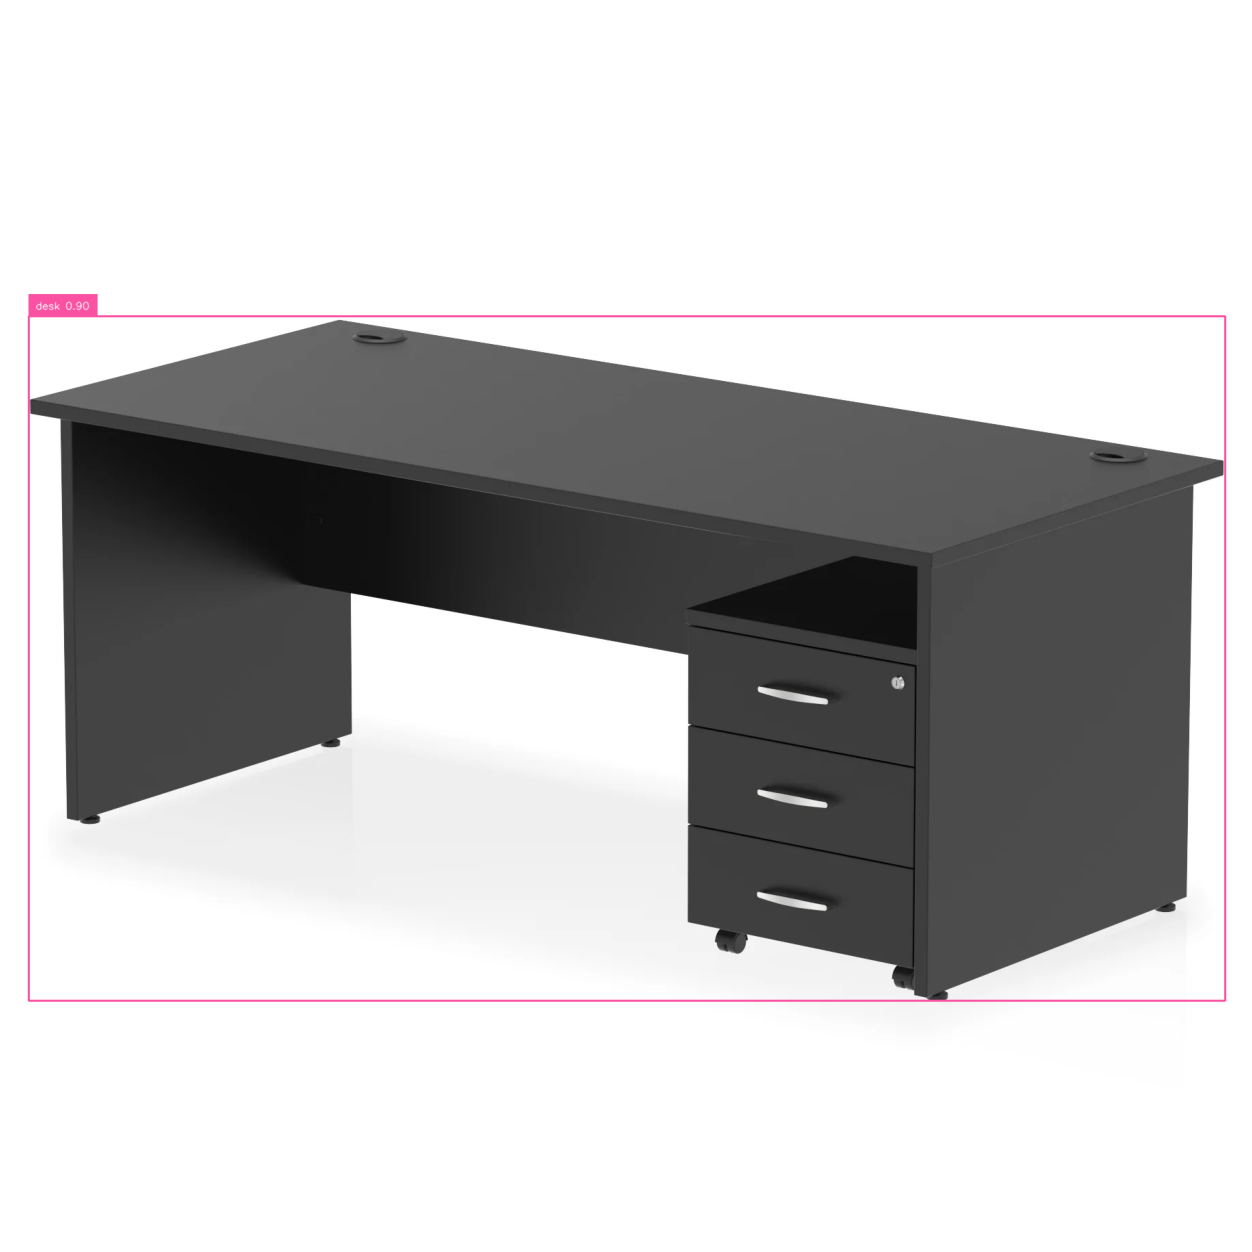

In [30]:
import os
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert
import supervision as sv

IMAGE_PATH = '/content/I005417_1.png'

TEXT_PROMPT = "desk"

image_source, image = load_image(IMAGE_PATH)
Image.fromarray(image_source)

def detect(image, text_prompt, model, box_threshold = 0.35, text_threshold = 0.35):
  boxes, logits, phrases = predict(
      model=model_GDino,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

annotated_frame, detected_boxes = detect(image, text_prompt=TEXT_PROMPT, model=model_GDino)
print(detected_boxes)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [31]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

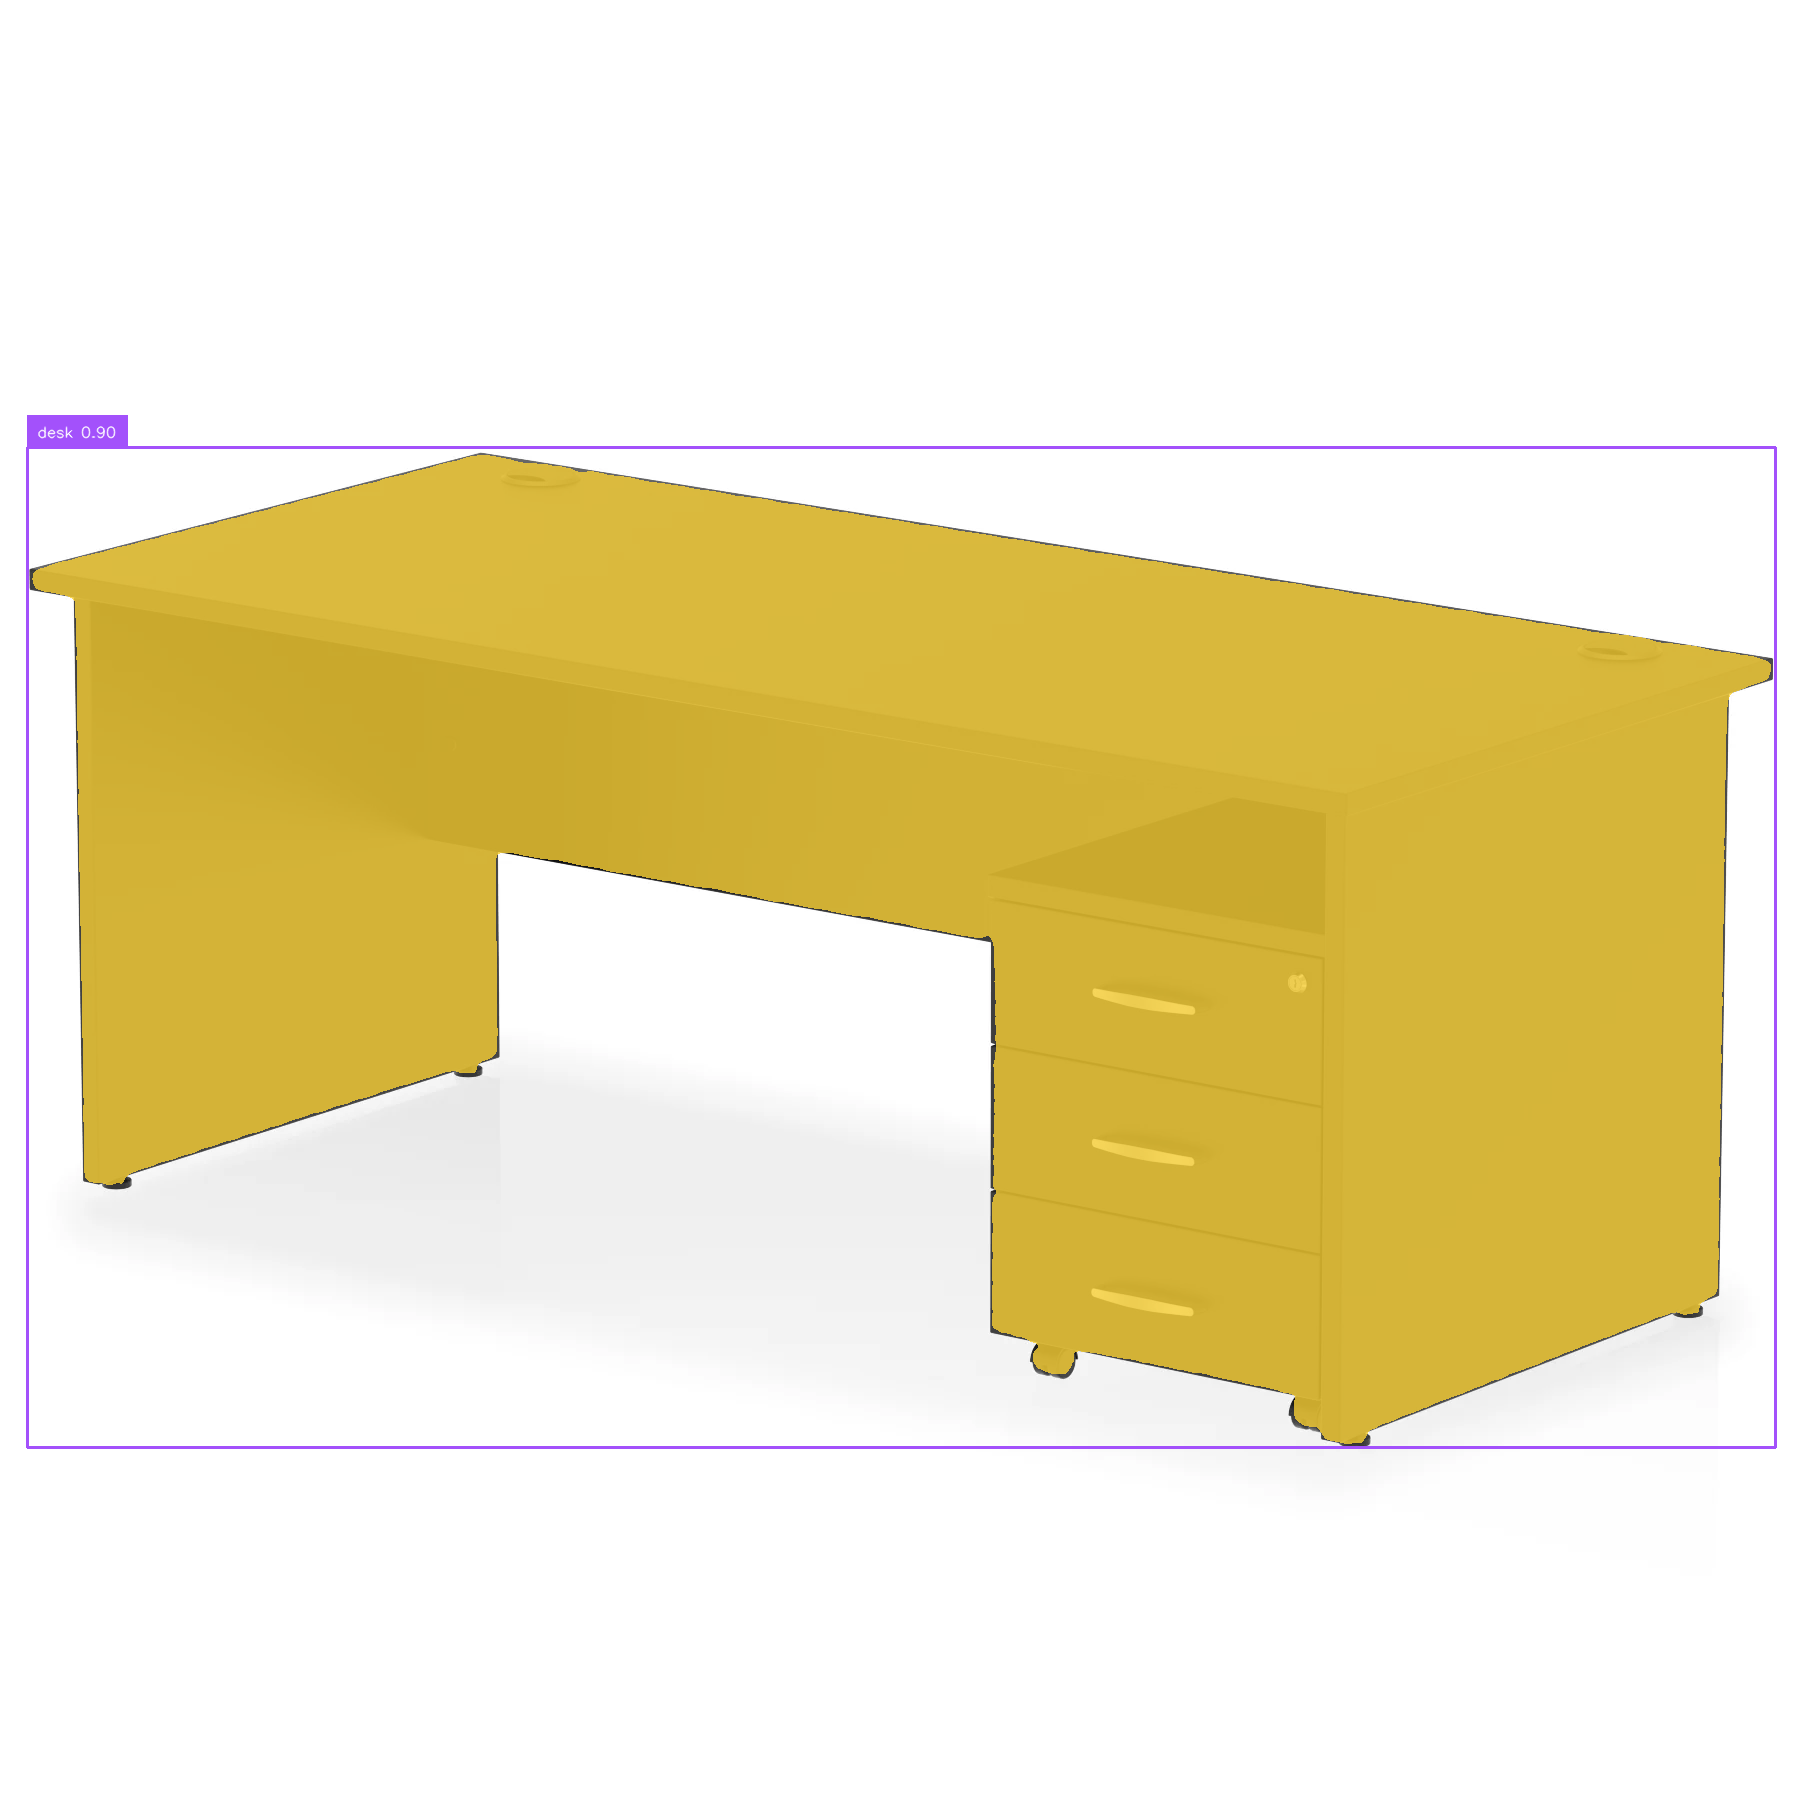

In [32]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

In [33]:
# mask: 0/1 float，先转成uint8掩码
mask = segmented_frame_masks[0][0].cpu().numpy()
mask_uint8 = (mask * 255).astype(np.uint8)

# 获取掩码区域坐标
coords = np.where(mask_uint8 == 255)
y1, y2 = np.min(coords[0]), np.max(coords[0])
x1, x2 = np.min(coords[1]), np.max(coords[1])

# 裁剪原图
object_crop = image_source[y1:y2, x1:x2]

# 保存/展示
cv2.imwrite("crop.png", object_crop)

True

In [34]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import faiss
import os
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-small')
model_dinoV2 = AutoModel.from_pretrained('facebook/dinov2-small').to(device)
model_dinoV2.eval()

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06,

In [35]:
def load_images_from_folder(folder):
    images = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append(os.path.join(root, file))
    return images

def add_embedding_to_index(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    index.add(vector)

def show_images(image_paths):
    n = len(image_paths)
    plt.figure(figsize=(5*n, 5))
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

In [36]:
def search_similar_images(query_image_path, category, k=5):
    folder = f"/content/drive/MyDrive/pix3d/img/{category}"
    image_paths = load_images_from_folder(folder)

    index_path = os.path.join("/content/drive/MyDrive/faiss_indices", f"{category}_index.faiss")
    index = faiss.read_index(index_path)

    img = Image.open(query_image_path).convert('RGB')
    with torch.no_grad():
        inputs = processor(images=img, return_tensors="pt").to(device)
        outputs = model_dinoV2(**inputs)
        features = outputs.last_hidden_state.mean(dim=1)
        vector = features.detach().cpu().numpy().astype('float32')
        faiss.normalize_L2(vector)
        D, I = index.search(vector, k)

    result_paths = [image_paths[i] for i in I[0]]
    return D[0], result_paths

Similar Img Path： ['/content/drive/MyDrive/pix3d/img/desk/0216.jpg', '/content/drive/MyDrive/pix3d/img/desk/0443.jpg', '/content/drive/MyDrive/pix3d/img/desk/0425.jpg', '/content/drive/MyDrive/pix3d/img/desk/0468.jpeg', '/content/drive/MyDrive/pix3d/img/desk/0546.jpg']


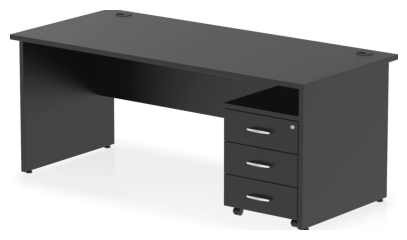

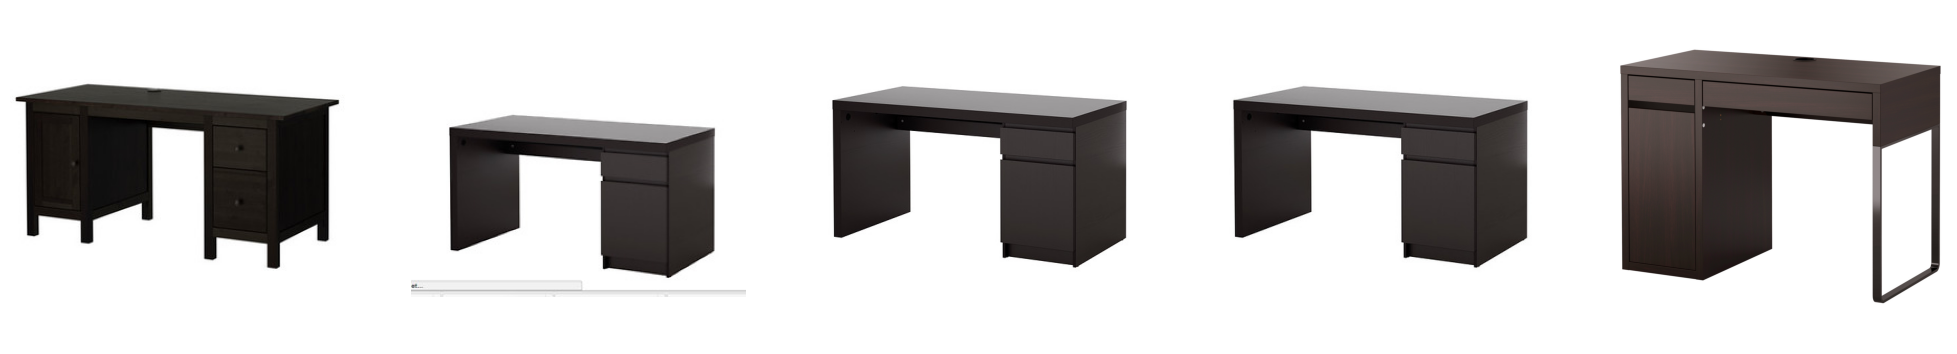

In [37]:
query_image = "/content/segment-anything/crop.png"

category = 'desk'

distances, result_image_paths = search_similar_images(query_image, category, k=5)

print("Similar Img Path：", result_image_paths)

show_images([query_image])
show_images(result_image_paths)

In [38]:
import os
import json

# 加载 pix3d.json
with open("/content/drive/MyDrive/pix3d/pix3d.json", "r") as f:
    pix3d_data = json.load(f)

# 定义查找函数
def get_model_path(img_path):
    for item in pix3d_data:
        if item["img"] == img_path:
            return item["model"], item["bbox"]
    return None

# 设定根目录
root_dir = "/content/drive/MyDrive/pix3d"

# 遍历所有相似图片路径，查找对应3D模型路径
model_paths = []
model_length = []
for full_path in result_image_paths:
    relative_path = full_path.split("pix3d/")[1]
    model_relative_path, bbox = get_model_path(relative_path)
    if model_relative_path:
        model_full_path = os.path.join(root_dir, model_relative_path)
        model_paths.append(model_full_path)
    else:
        print(f"No model found")

    if bbox:
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        model_length.append([width,height])

# 打印最终结果
print("5个相似图片对应的3D模型路径：")
for i, path in enumerate(model_paths):
    print(f"Top-{i+1}: {path}")

5个相似图片对应的3D模型路径：
Top-1: /content/drive/MyDrive/pix3d/model/desk/IKEA_HEMNES/model.obj
Top-2: /content/drive/MyDrive/pix3d/model/desk/IKEA_MALM/model.obj
Top-3: /content/drive/MyDrive/pix3d/model/desk/IKEA_MALM/model.obj
Top-4: /content/drive/MyDrive/pix3d/model/desk/IKEA_MALM/model.obj
Top-5: /content/drive/MyDrive/pix3d/model/desk/IKEA_MICKE_2/model.obj


In [39]:
import trimesh

scene = trimesh.load(model_paths[0])
print(f"Model's width, height is {model_length[0]}")

scene.show()

Model's width, height is [312, 176]
